In [2]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

# !pip install opencv-python-headless
import cv2
from matplotlib.patches import Rectangle
from typing import List, Tuple
import itertools
from copy import copy, deepcopy
import os
import shutil
from functools import reduce

import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError

  Using cached opencv_python_headless-4.5.3.56-cp38-cp38-manylinux2014_x86_64.whl (37.1 MB)


In [3]:
####################################
# Read dataset
####################################

# import heat extremes data
fn = f"Ext_max_t__Rgn_1__2015__Abv_Avg_5_K_for_4_days__CMIP6_ssp245_Avg_yrs_1950_79.nc"
ds = xr.open_mfdataset(fn)

print(ds.attrs['Number of continuous days to be considered extreme'], "days")
print(ds.attrs['threshold'], "K above")

4 days
5 K above


In [145]:
ds

<xarray.Dataset>
Dimensions:          (time: 365, lat: 284, lon: 644)
Coordinates:
  * time             (time) object 2015-01-01 12:00:00 ... 2015-12-31 12:00:00
  * lat              (lat) float64 14.12 14.38 14.62 14.88 ... 84.38 84.62 84.88
  * lon              (lon) float64 190.1 190.4 190.6 190.9 ... 350.4 350.6 350.9
Data variables:
    tasmax           (time, lat, lon) float32 dask.array<chunksize=(365, 284, 644), meta=np.ndarray>
    above_threshold  (time, lat, lon) float32 dask.array<chunksize=(365, 284, 644), meta=np.ndarray>
    extreme_yn       (time, lat, lon) float64 dask.array<chunksize=(365, 284, 644), meta=np.ndarray>
Attributes: (12/24)
    Dataset:                                             1-year Extreme max T...
    About dataset:                                       1-year Extreme max T...
    Data variables:                                      tasmax, above_thresh...
    Data description:                                    max temperature; dif...
    Range:                                               1 year
    Analysis year:                                       2015
    ...                                                  ...
    region_bottom_lat:                                   14
    region_left_lon:                                     190
    region_right_lon:                                    350
    region_img_url:                                      https://github.com/t...
    Years processed:                                     1
    Store as:                                            Ext_max_t__Rgn_1__20...

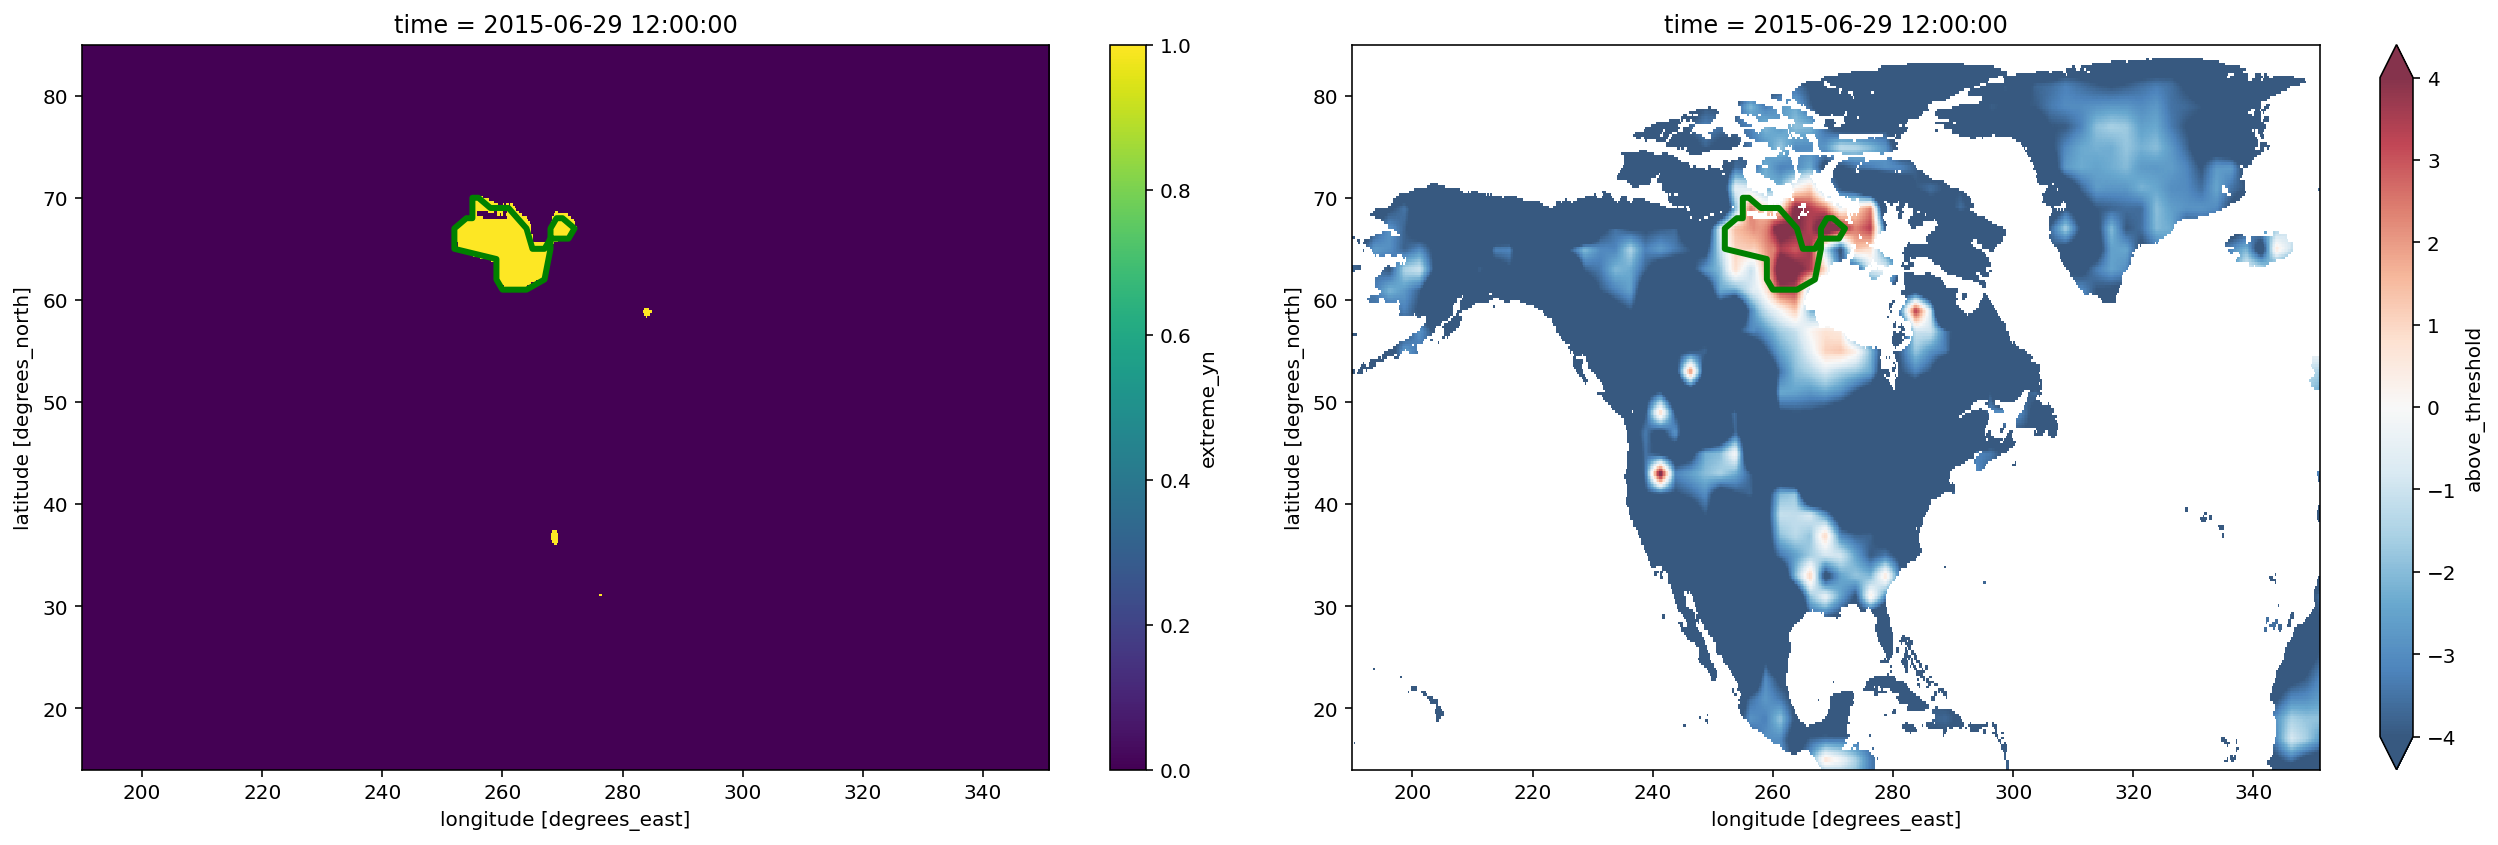

In [301]:
####################################
# NEW bounding-grids algotihm pipeline
####################################

"""
NEW, bounding-contours algorithm to find the extend of the heat events and
produce visualizations. It uses the the heat events y/n dataset 
which was (supposed to be pre-) produced by the "Heatwave Analysis" algorithm. 
"""

def find_contours(arr2d: np.array, extend=False) -> List[np.array]:
    """Encapsulate islands of 1s and return contours, [(i,j),(..),]."""
    H = arr2d.astype(np.uint8)
    ret, thresh = cv2.threshold(H, 0, 1, 0, cv2.THRESH_BINARY)
    
    kernel = np.ones((10,10), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if extend:
        contours = [cv2.convexHull(c) for c in contours]
    contours = [c for c in contours if c.shape[0]>1] # filter single points
    
    return contours

LONS = ds.coords['lon']
LATS = ds.coords['lat']
SMOOTH_RATIO = 0.005
AREA_TRESH = 50
IMG_SHAPE = (ds.dims['lat'], ds.dims['lon'])

 
class Contour():

    def __init__(self, cnt:np.array):
        self.contour = cnt
        self.area = cv2.contourArea(cnt)
        self.smoothened = cv2.approxPolyDP(cnt, SMOOTH_RATIO*cv2.arcLength(cnt,True),True)
        _proj = [(float(LONS[x]), float(LATS[y])) for (x,y) in self.smoothened.squeeze()]
        self.projected = np.array(_proj).reshape((-1,1,2)).astype(np.int32)
       
    def overlaps(self, obj2:object) -> bool:
        """Check if two contour objects overlap."""
        ctrs = [self.contour, obj2.contour]
        zeros = np.zeros(IMG_SHAPE)
        img1 = cv2.drawContours(zeros.copy(), ctrs, 0, 1)
        img2 = cv2.drawContours(zeros.copy(), ctrs, 1, 1)
        intersection = np.logical_and(img1, img2)
        return intersection.any()
    
    def __add__(self, obj2):
        """Fuse two countor objects, if they overlap."""
        if self.overlaps(obj2):
            c1, c2 = self.contour, obj2.contour
            fused = cv2.convexHull(np.vstack([c1, c2]))
            return (self.__class__(fused), )
        else:
            return (self, obj2)
        
####################################
# Visualize
####################################

# store some meta data for easy access
dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))

# create plot(s)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

# select the day to plot
idx = 179

day = dr[idx].strftime("%Y-%m-%d")
tasmax = ds['tasmax'].sel(time=day)
tdiff = ds['above_threshold'].sel(time=day)
extreme = ds['extreme_yn'].sel(time=day)

im1 = extreme.squeeze().plot.imshow(ax=ax1)
im2 = tdiff.squeeze().plot.imshow(ax=ax2, cmap='RdBu_r', vmin=4, vmax=-4, alpha=0.8)

# find bounding contours
arr2d = extreme.values[0]
contours = find_contours(arr2d, extend=False) 
contours = [Contour(c) for c in contours]
contours = [c for c in contours if c.area>150]
contours = [c.projected.squeeze() for c in contours]

# add these patches on the plot(s)
patches = [Polygon(c, True) for c in contours]

args = dict(edgecolors=("g",), linewidths=(3,), facecolor="none",)
p = PatchCollection(patches, **args)
ax1.add_collection(p)
p = PatchCollection(patches, **args)
ax2.add_collection(p)

fig.tight_layout()
